## Introduction

Detect fraudulent emails.

In [ ]:
# Enter the s3 path of the input data file
s3_source_file="<<s3://mybaucket/fraud.csv"

In [ ]:
# Enter the s3 path of the output data file
bucket = 'aegovansagemaker' # Replace with your own bucket name if needed, this is the destination bucket
prefix = 'cs_emailfraud/sagemaker' 

## Setup

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting. If you don't specify a bucket, SageMaker SDK will create a default bucket following a pre-defined naming convention in the same region. 
- The IAM role ARN used to give SageMaker access to your data. It can be fetched using the **get_execution_role** method from sagemaker python SDK.

In [ ]:
!pip install scikit-plot==0.3.7
!pip install numpy==1.15.1
!pip install matplotlib==2.7.3
!pip install scikit-learn==0.20.0
!pip install nltk==3.3
!pip install pandas==0.22.0
!pip install sagemaker==1.10.1  


In [46]:
import sagemaker
from sagemaker import get_execution_role
import json
import boto3

sess = sagemaker.Session()

role = get_execution_role()


### Download data from S3

In [1]:
local_tmp_dir="tmp"
inputfile="{}/data.csv".format(local_tmp_dir)
!mkdir -p local_tmp_dir

In [ ]:

!aws s3 cp $s3_source_file $inputfile

In [ ]:
!head $inputfile

### Prepare the dataset

Reformat the file as expected by blazing text with no header

In [11]:
import csv
import nltk


def get_data(inputfile):
    nltk.download('punkt')
    data = []
    with open(inputfile, "r") as i:
        csv_reader = csv.reader(i, delimiter=",", quotechar='"')
        # Ignore head
        next(csv_reader)
        for l in csv_reader:
            raw_label= l[5]
            label="__label__{}".format(raw_label)
            text = "{}".format(l[4]).replace("\n", "")
            tokens = nltk.word_tokenize(l[4].lower())      
            data.append({"label" : raw_label, "text":text, "tokens": tokens})

    return data
        


   
        
    

In [12]:

data_list = get_data(inputfile)


[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Analyse the dataset

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.DataFrame(data_list)


In [15]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 100)

In [14]:
print("Total no of records in the dataset {}".format(data.shape[0]))

Total no of records in the dataset 64045


Let us inspect the dataset and the classes to get some understanding about how the data and the label is provided in the dataset. 

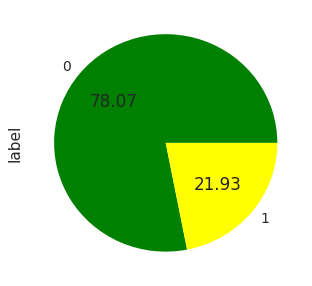

In [47]:
data["label"].value_counts().plot.pie(autopct='%.2f',figsize=(5, 5), colors=["green","yellow"])
plt.title = "Fraud class distribution"
plt.show()

In [18]:
num_classes = data["label"].nunique()

In [48]:
data.head(n=3)

,label,text,tokens
0,1,your kidding me.. thats a bomb.. $100 if even that mate.. jesus,"[your, kidding, me.., thats, a, bomb.., $, 100, if, even, that, mate.., jesus]"
1,1,Wondering if you may be interested in putting your boat on consignment with us at dAboras Marina The Spit any interest p[lease call,"[wondering, if, you, may, be, interested, in, putting, your, boat, on, consignment, with, us, at, daboras, marina, the, spit, any, interest, p, [, lease, call]"
2,1,Would you be interested in putting your boat on consignment with us at dAlboras marina The Spit,"[would, you, be, interested, in, putting, your, boat, on, consignment, with, us, at, dalboras, marina, the, spit]"


Split Data into Train, Test and Validation

In [49]:
from sklearn.model_selection import train_test_split, learning_curve
train, validation = train_test_split(data, test_size = 0.2, random_state = 777)


View the class distribution for the train and validation set

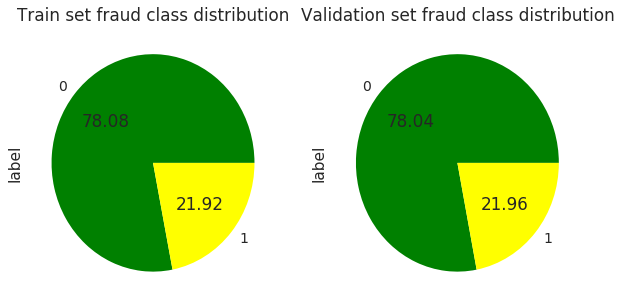

In [50]:
fig, ax = plt.subplots( 1,2, figsize=(10,5))
axis=ax[0]
train["label"].value_counts().plot.pie(autopct='%.2f', colors=["green","yellow"], ax=axis)
axis.set_title("Train set fraud class distribution")

axis=ax[1]
validation["label"].value_counts().plot.pie(autopct='%.2f', colors=["green","yellow"], ax=axis)
axis.set_title("Validation set fraud class distribution")
plt.show()

#### Prepare the dataset file for Blazing text
The first column should be the label formatted as \__label__<labelname\>

In [ ]:
import csv

def write_formatted_file(data, outputfile):
    with open(outputfile , "w") as o:
        for index, row in data.iterrows():
            label="__label__{}".format(row["label"])
            token_sep_space=" ".join(row["tokens"])
            o.write("{} {}\n".format(label, token_sep_space))

In [ ]:
from sklearn.model_selection import train_test_split, learning_curve


formatted_train_file="{}/train.txt".format(local_tmp_dir)
formatted_validation_file="{}/validation.txt".format(local_tmp_dir)


write_formatted_file(train, formatted_train_file)
write_formatted_file(validation, formatted_validation_file)

This is how the formatted file looks like.

In [ ]:
!head $formatted_train_file

The data preprocessing cell might take a minute to run. After the data preprocessing is complete, we need to upload it to S3 so that it can be consumed by SageMaker to execute training jobs. We'll use Python SDK to upload these two files to the bucket and prefix location that we have set above.   

In [ ]:
%%time

train_channel = prefix + '/train'
validation_channel = prefix + '/validation'

sess.upload_data(path=formatted_train_file, bucket=bucket, key_prefix=train_channel)
sess.upload_data(path=formatted_validation_file, bucket=bucket, key_prefix=validation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)


Next we need to setup an output location at S3, where the model artifact will be dumped. These artifacts are also the output of the algorithm's traning job.

In [ ]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

## Training
Now that we are done with all the setup that is needed, we are ready to train our object detector. To begin, let us create a ``sageMaker.estimator.Estimator`` object. This estimator will launch the training job.

In [ ]:
region_name = boto3.Session().region_name
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'blazingtext')

## Training the BlazingText model for supervised text classification

In [ ]:
bt_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.c4.4xlarge',
                                         train_volume_size = 30,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

Please refer to [algorithm documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext_hyperparameters.html) for the complete list of hyperparameters.

In [ ]:
bt_model.set_hyperparameters(mode="supervised",
                            epochs=600,
                            min_count=2,
                            learning_rate=0.05,
                            vector_dim=150,
                            early_stopping=True,
                            patience=50,
                            min_epochs=5,
                            subwords=False,
                            word_ngrams=3)

Now that the hyper-parameters are setup, let us prepare the handshake between our data channels and the algorithm. To do this, we need to create the `sagemaker.session.s3_input` objects from our data channels. These objects are then put in a simple dictionary, which the algorithm consumes.

In [ ]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='text/plain', s3_data_type='S3Prefix')
data_channels = {'train': train_data, 'validation': validation_data}

In [ ]:
bt_model.fit(inputs=data_channels, logs=True)

In [ ]:
%%time
import boto3
from time import gmtime, strftime
sagemaker_session = sagemaker.Session()
model_name="blazingtextemailfraud" + '-model-' +  strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(model_name)

chainer_training_job = bt_model.latest_training_job.name
desc = sagemaker_session.sagemaker_client.describe_training_job(TrainingJobName=chainer_training_job)
model_data = desc['ModelArtifacts']['S3ModelArtifacts']

print(model_data)

primary_container = {
    'Image': container,
    'ModelDataUrl': model_data
}

client = boto3.client('sagemaker')
create_model_response = client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

## Inference using sagemaker batch transform

In [2]:
batchfileinput="{}/batchtest.json".format(local_tmp_dir)
batchfileoutput="{}/batchtest.output.json".format(local_tmp_dir)

#### Create a json file that is formatted  for blazing text inference
It kind of looks like
```json
{
  "instances": ["hey mate , very interested in this", "does it include a rwc ?", "hi is your volvo"],
  "configuration": {
    "k": 2
  }
}
```

In [19]:
%%time

import json
from itertools import islice
import math
import struct
import json

test_data = validation

input_records = [" ".join(l["tokens"]) for index, l in test_data.iterrows()]
labels = ["__label__{}".format(l["label"]) for index, l  in test_data.iterrows() ]

input_json = {"instances" : input_records, "configuration": {"k": num_classes}}
with open(batchfileinput , "w") as f:
    f.write(json.dumps(input_json))
                                          

CPU times: user 1.74 s, sys: 12 ms, total: 1.75 s
Wall time: 1.75 s


In [ ]:
%%time
import boto3
import sagemaker
import json

fmttime= strftime("%Y-%m-%d-%H-%M-%S", gmtime())
input_key_file="batchvalidation.csv"
input_batch_key="{}/batchTransform/{}_input/{}".format(prefix, fmttime, input_key_file)
input_location = 's3://{}/{}'.format(bucket, input_batch_key)
output_batch_key = "{}/batchTransform/{}_output".format(prefix,fmttime)
output_location = 's3://{}/{}'.format(bucket, output_batch_key)


s3_client = boto3.client('s3')
s3_client.upload_file(batchfileinput, bucket, input_batch_key)

# Initialize the transformer object
transformer =sagemaker.transformer.Transformer(
    base_transform_job_name='Batch-Transform',
    model_name=model_name,
    instance_count=1,
    instance_type='ml.c4.xlarge',
    output_path=output_location
    )
# To start a transform job:
transformer.transform(input_location, content_type='application/json')
# Then wait until transform job is completed
transformer.wait()

# To fetch validation result 
outputkey ='{}/{}.out'.format(output_batch_key, input_key_file)
print(outputkey)
s3_client.download_file(bucket, outputkey, batchfileoutput)



In [20]:
import json

with open(batchfileoutput) as f:
    predicted = json.load(f)



The output of Blazing text inference looks like this
```json
[{
    'prob': [0.9910072088241577, 0.00901278480887413],
    'label': ['__label__0', '__label__1']
  }, {
    'prob': [0.9973444938659668, 0.002675538882613182],
    'label': ['__label__1', '__label__0']
  }, {
    'prob': [0.9969576001167297, 0.003062397940084338],
    'label': ['__label__0', '__label__1']
  ]
]
```

So lets format it so that we can analyse the performance

In [21]:
predicted_labels = [ r['label'][r['prob'].index(max(r['prob']))] for r in predicted]
predicted_confidence_score = [ max(r['prob'])/sum(r['prob']) for r in predicted]



Convert the label format \__label__1 to 1 , as the scores work on numeric labels only

In [22]:
import pandas as pd

y_actual = pd.DataFrame(labels, columns = ["label"]) #== "__label__1"
y_pred = pd.DataFrame(predicted_labels, columns = ["predicted_label"]) #== "__label__1"
y_confidence_score =  pd.DataFrame(predicted_confidence_score, columns = ["predicted_label_confidence_score"])

In [23]:
import numpy as np
unique_classes = predicted[0]['label']

y_classwise_prob = pd.DataFrame(0, index=np.arange(len(predicted)), columns=unique_classes)
for c in unique_classes:
    y_classwise_prob[c] = pd.DataFrame([ r['prob'][r['label'].index(c)]/sum(r['prob']) for r in predicted])



### Evaluate the performance

In [24]:


y_display= pd.DataFrame()
y_display["predicted_label"] = y_pred["predicted_label"]
y_display['confidence_score'] = y_confidence_score["predicted_label_confidence_score"]
y_display['score_postive_class'] = y_classwise_prob["__label__1"]
y_display['actual'] = y_actual['label']
y_display.head(n=10)



,predicted_label,confidence_score,score_postive_class,actual
0,__label__0,0.994936,0.005064,__label__0
1,__label__1,0.998191,0.998191,__label__1
2,__label__0,0.997659,0.002341,__label__0
3,__label__0,0.997668,0.002332,__label__0
4,__label__0,0.892638,0.107362,__label__0
5,__label__0,0.999965,0.000035,__label__0
6,__label__0,0.999986,0.000014,__label__1
7,__label__0,0.999031,0.000969,__label__0
8,__label__0,0.999990,0.000010,__label__0
9,__label__0,0.999703,0.000297,__label__0


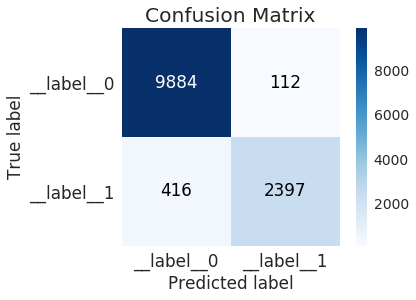

In [52]:
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_confusion_matrix(y_actual, y_pred, labels=None, true_labels=None, pred_labels=None, title=None, normalize=False, hide_zeros=False, hide_counts=False, x_tick_rotation=0, ax=None, figsize=None, cmap='Blues', title_fontsize='large', text_fontsize='medium')
plt.show()

In [43]:
import sklearn
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_fscore_support
import numpy as np

## Precision recall
macro_score = sklearn.metrics.average_precision_score( y_actual, y_classwise_prob["__label__1"] ,  pos_label = "__label__1")
f1score = sklearn.metrics.f1_score(y_actual, y_pred , pos_label = "__label__1", average='binary')
precision = sklearn.metrics.precision_score(y_actual, y_pred ,  pos_label = "__label__1", average='binary')
recall = sklearn.metrics.recall_score( y_actual, y_pred ,  pos_label = "__label__1", average='binary')

## Unweighted ROC
acc = accuracy_score(y_actual, y_pred)
fpr, tpr, _ = roc_curve(y_actual,y_classwise_prob["__label__1"], pos_label="__label__1")
roc_auc = auc(fpr, tpr)

print("The AUC under precision recall curve is {}".format( macro_score))
print("F1 score {}".format(f1score))
print("Precision score {}".format(precision))
print("Recall score {}".format(recall))
print("Accuracy {}".format( roc_auc))
print("Area Under ROC curve {}".format( roc_auc))



The AUC under precision recall curve is 0.9495300682796007
F1 score 0.9007891770011274
Precision score 0.9553607014746911
Recall score 0.8521151795236402
Accuracy 0.9793406697908457
Area Under ROC curve 0.9793406697908457


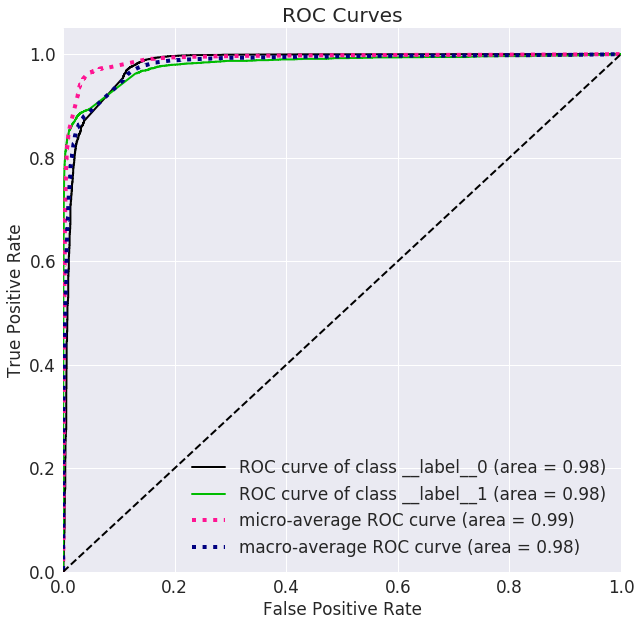

In [45]:
import scikitplot as skplt
import matplotlib.pyplot as plt

y_true =  y_actual# ground truth labels
skplt.metrics.plot_roc(y_true, y_classwise_prob, figsize=(10,10))
plt.show()